In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import neighbors
from sklearn.linear_model import LassoCV,RidgeCV
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import TheilSenRegressor
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import ExtraTreesRegressor
import matplotlib._color_data as mcd
from sklearn.ensemble import IsolationForest
from matplotlib.pyplot import plot, xlabel, ylabel
from sklearn.decomposition import PCA
import seaborn as sns
from warnings import filterwarnings
filterwarnings("ignore")

In [2]:
data = pd.read_csv('measures_v2.csv')
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1330816 entries, 0 to 1330815
Data columns (total 13 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   u_q             1330816 non-null  float64
 1   coolant         1330816 non-null  float64
 2   stator_winding  1330816 non-null  float64
 3   u_d             1330816 non-null  float64
 4   stator_tooth    1330816 non-null  float64
 5   motor_speed     1330816 non-null  float64
 6   i_d             1330816 non-null  float64
 7   i_q             1330816 non-null  float64
 8   pm              1330816 non-null  float64
 9   stator_yoke     1330816 non-null  float64
 10  ambient         1330816 non-null  float64
 11  torque          1330816 non-null  float64
 12  profile_id      1330816 non-null  int64  
dtypes: float64(12), int64(1)
memory usage: 132.0 MB


,u_q,coolant,stator_winding,u_d,stator_tooth,motor_speed,i_d,i_q,pm,stator_yoke,ambient,torque,profile_id
0,-0.450682,18.805172,19.086670,-0.350055,18.293219,0.002866,0.004419,0.000328,24.554214,18.316547,19.850691,0.187101,17
1,-0.325737,18.818571,19.092390,-0.305803,18.294807,0.000257,0.000606,-0.000785,24.538078,18.314955,19.850672,0.245417,17
2,-0.440864,18.828770,19.089380,-0.372503,18.294094,0.002355,0.001290,0.000386,24.544693,18.326307,19.850657,0.176615,17
3,-0.327026,18.835567,19.083031,-0.316199,18.292542,0.006105,0.000026,0.002046,24.554018,18.330833,19.850647,0.238303,17
4,-0.471150,18.857033,19.082525,-0.332272,18.291428,0.003133,-0.064317,0.037184,24.565397,18.326662,19.850639,0.208197,17


In [3]:
data=data.drop("profile_id",axis=1)

In [4]:
# dtype change to reduce memory usage
#torque will have 0's after conversion, so it should has same dtype
float_col = [x for x in data.columns if x!="torque"]

for f in float_col:
    data[f] = data[f].astype("float32")


In [6]:
data.info()
data.head()
(data == 0).sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1330816 entries, 0 to 1330815
Data columns (total 12 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   u_q             1330816 non-null  float32
 1   coolant         1330816 non-null  float32
 2   stator_winding  1330816 non-null  float32
 3   u_d             1330816 non-null  float32
 4   stator_tooth    1330816 non-null  float32
 5   motor_speed     1330816 non-null  float32
 6   i_d             1330816 non-null  float32
 7   i_q             1330816 non-null  float32
 8   pm              1330816 non-null  float32
 9   stator_yoke     1330816 non-null  float32
 10  ambient         1330816 non-null  float32
 11  torque          1330816 non-null  float64
dtypes: float32(11), float64(1)
memory usage: 66.0 MB


u_q               0
coolant           0
stator_winding    0
u_d               0
stator_tooth      0
motor_speed       0
i_d               0
i_q               0
pm                0
stator_yoke       0
ambient           0
torque            0
dtype: int64

In [7]:
# define pair plot
def pair_plot(data, colname, sample_num=1000):
    samp = data[colname].sample(sample_num)
    sns.pairplot(samp)

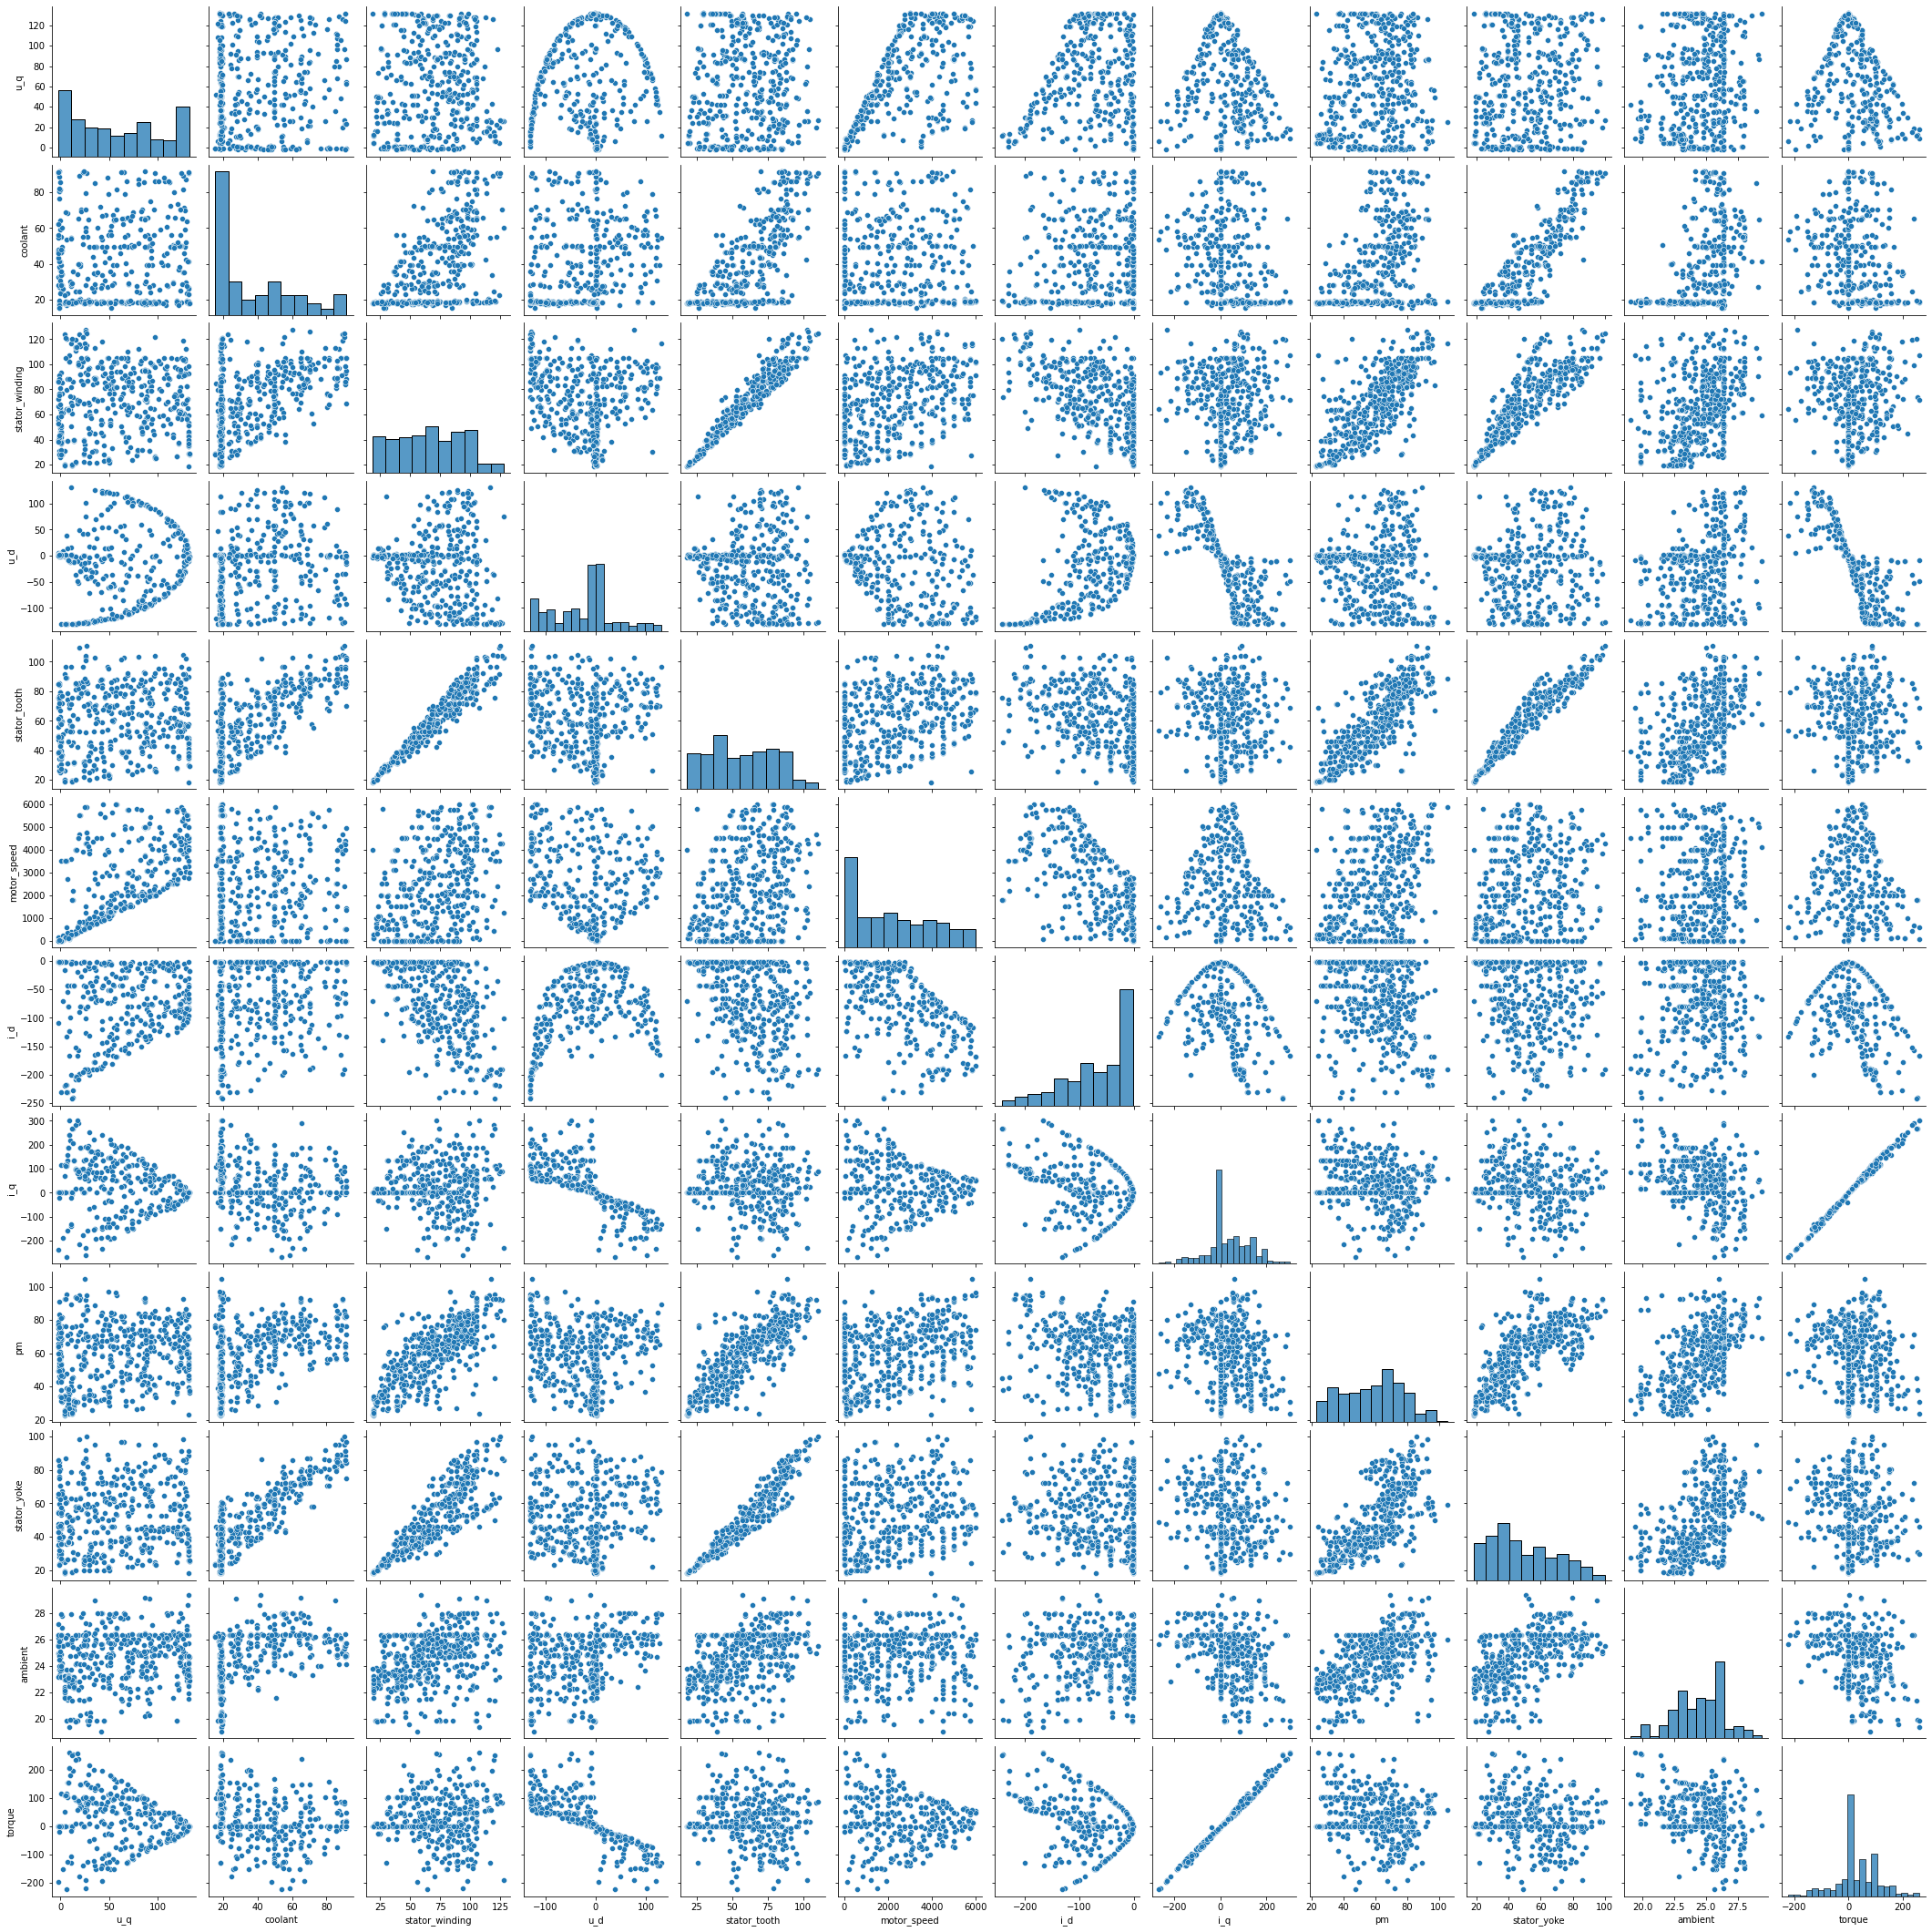

In [8]:
# plot
pair_plot(data=data, colname=data.columns, sample_num=500)

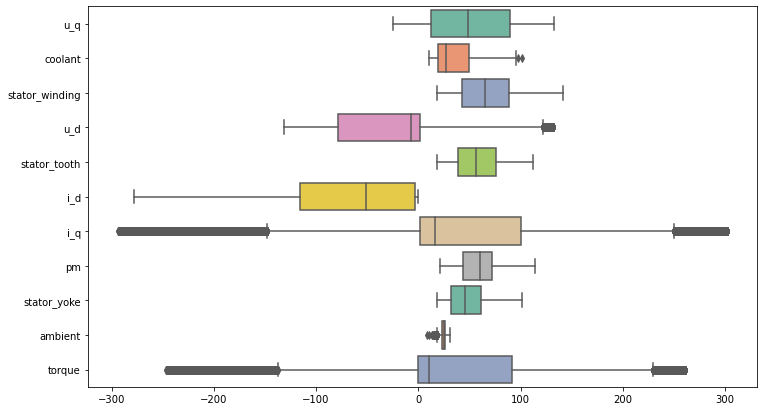

<AxesSubplot:>

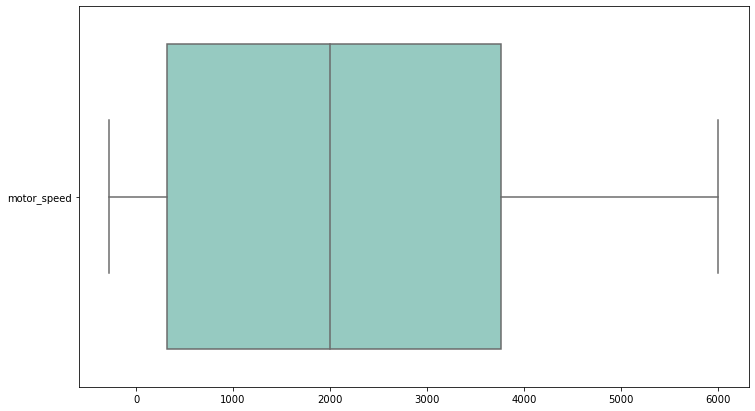

In [9]:
plt.figure(figsize = (12,7))
sns.boxplot(data=data[data.columns.drop(['motor_speed'])],orient="h", palette="Set2")
plt.show()
plt.figure(figsize = (12,7))
sns.boxplot(data=data[['motor_speed']],orient="h", palette="Set3")

In [10]:
#outlier detect, data is too big, leave intuitively 0.9 of data
iso = IsolationForest(contamination=0.10)
yhat = iso.fit_predict(data)
# select all rows that are not outliers
mask = yhat != -1
data = data.iloc[mask, :]
data

,u_q,coolant,stator_winding,u_d,stator_tooth,motor_speed,i_d,i_q,pm,stator_yoke,ambient,torque
0,-0.450682,18.805172,19.086670,-0.350055,18.293219,0.002866,0.004419,0.000328,24.554214,18.316547,19.850691,1.871008e-01
1,-0.325737,18.818571,19.092390,-0.305803,18.294807,0.000257,0.000606,-0.000785,24.538078,18.314955,19.850672,2.454175e-01
2,-0.440864,18.828770,19.089380,-0.372503,18.294094,0.002355,0.001290,0.000386,24.544693,18.326307,19.850657,1.766153e-01
3,-0.327026,18.835567,19.083031,-0.316199,18.292542,0.006105,0.000026,0.002046,24.554018,18.330833,19.850647,2.383027e-01
4,-0.471150,18.857033,19.082525,-0.332272,18.291428,0.003133,-0.064317,0.037184,24.565397,18.326662,19.850639,2.081967e-01
...,...,...,...,...,...,...,...,...,...,...,...,...
1330811,-2.152128,30.721298,45.274498,0.791801,41.934345,0.000380,-2.000169,1.097528,62.147781,38.653721,23.989079,-8.116730e-60
1330812,-2.258683,30.721306,45.239017,0.778900,41.868923,0.002985,-2.000499,1.097569,62.142647,38.656326,23.970701,-5.815891e-60
1330813,-2.130312,30.721312,45.211575,0.804914,41.804821,0.002301,-1.999269,1.098765,62.138386,38.650925,23.977234,-4.167268e-60
1330814,-2.268498,30.721315,45.193508,0.763091,41.762218,0.005662,-2.000998,1.095696,62.133423,38.655685,24.001421,-2.985978e-60


In [11]:
scaler = StandardScaler()
data.loc[:]=scaler.fit_transform(data)
data.head()

,u_q,coolant,stator_winding,u_d,stator_tooth,motor_speed,i_d,i_q,pm,stator_yoke,ambient,torque
0,-1.236805,-0.764387,-1.645783,0.471340,-1.695032,-1.149404,0.994449,-0.517929,-1.787059,-1.518152,-2.513183,-0.514180
1,-1.234023,-0.763711,-1.645566,0.472102,-1.694957,-1.149405,0.994388,-0.517943,-1.787945,-1.518241,-2.513193,-0.513300
2,-1.236587,-0.763196,-1.645680,0.470954,-1.694991,-1.149404,0.994399,-0.517929,-1.787582,-1.517610,-2.513201,-0.514339
3,-1.234052,-0.762853,-1.645921,0.471923,-1.695065,-1.149402,0.994379,-0.517908,-1.787070,-1.517358,-2.513206,-0.513407
4,-1.237261,-0.761769,-1.645940,0.471646,-1.695118,-1.149404,0.993357,-0.517467,-1.786446,-1.517590,-2.513210,-0.513862


In [12]:
def print_unique(data, col_names):
    for col in col_names:
        print(col, ': ', len(data[col].unique()))

In [13]:
columns = data.columns
print_unique(data,columns)

u_q :  1121506
coolant :  933942
stator_winding :  1065189
u_d :  1157150
stator_tooth :  1016503
motor_speed :  601619
i_d :  730283
i_q :  701481
pm :  1140244
stator_yoke :  1013648
ambient :  870025
torque :  937598


In [14]:
X = data.loc[:, data.columns != 'pm']
y=data['pm']

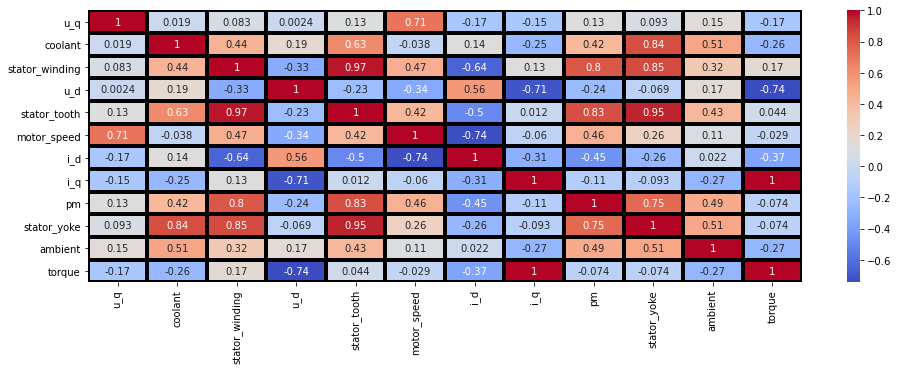

In [15]:
corrMatrix = data.corr()
plt.figure(figsize = (16,5))
sns.heatmap(corrMatrix, annot=True,cmap= 'coolwarm', linewidths=3, linecolor='black')
plt.show()

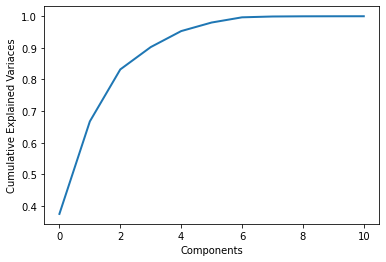

In [16]:
#highly correlated features 
pca = PCA().fit(X)
plot(np.cumsum(pca.explained_variance_ratio_), linewidth=2)
xlabel('Components')
ylabel('Cumulative Explained Variaces')
plt.show()

In [17]:
pca = PCA(n_components=7)
pca.fit(X)
X_pca = pca.transform(X)
print("original shape:   ", X.shape)
print("transformed shape:", X_pca.shape)

original shape:    (1197734, 11)
transformed shape: (1197734, 7)


In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=350)

In [19]:
models = [LinearRegression,
          LassoCV,RidgeCV,
          LGBMRegressor,
          XGBRegressor,
          GradientBoostingRegressor,
          RandomForestRegressor,
          DecisionTreeRegressor,
          MLPRegressor,
          KNeighborsRegressor,
          CatBoostRegressor,
          BaggingRegressor,
          TheilSenRegressor,
          AdaBoostRegressor,
          ElasticNet,
          ExtraTreesRegressor
          ]

In [20]:
accu=pd.DataFrame(index=['RMSE'])

In [21]:
def compML(alg):

    try:
        model = alg(n_jobs=-1).fit(X_train,y_train)
    except:
        model = alg().fit(X_train,y_train)
    #hummingbird implementation
    #model = convert(model, 'pytorch')
    #model=model.to('cuda')
    y_pred = model.predict(X_test)
    RMSE = np.sqrt(mean_squared_error(y_test,y_pred))
    model_name = alg.__name__
    print(model_name,'Test-set Error (RMSE):', RMSE)
    accu.insert(0, model_name,RMSE)
    


In [22]:
for i in models:
    compML(i)

LinearRegression Test-set Error (RMSE): 0.4568506661137521
LassoCV Test-set Error (RMSE): 0.45689589661349617
RidgeCV Test-set Error (RMSE): 0.4568506664919176
LGBMRegressor Test-set Error (RMSE): 0.2707146361352421
XGBRegressor Test-set Error (RMSE): 0.22127016946076974
GradientBoostingRegressor Test-set Error (RMSE): 0.35699293114688946
RandomForestRegressor Test-set Error (RMSE): 0.08212706199422833
DecisionTreeRegressor Test-set Error (RMSE): 0.12597784399253698
MLPRegressor Test-set Error (RMSE): 0.24909802132267067
KNeighborsRegressor Test-set Error (RMSE): 0.07345581972138127
Learning rate set to 0.129353
0:	learn: 0.9055913	total: 249ms	remaining: 4m 8s
1:	learn: 0.8258649	total: 302ms	remaining: 2m 30s
2:	learn: 0.7581614	total: 364ms	remaining: 2m
3:	learn: 0.6996898	total: 419ms	remaining: 1m 44s
4:	learn: 0.6460338	total: 484ms	remaining: 1m 36s
5:	learn: 0.6017640	total: 545ms	remaining: 1m 30s
6:	learn: 0.5656124	total: 605ms	remaining: 1m 25s
7:	learn: 0.5348977	total: 6

<AxesSubplot:>

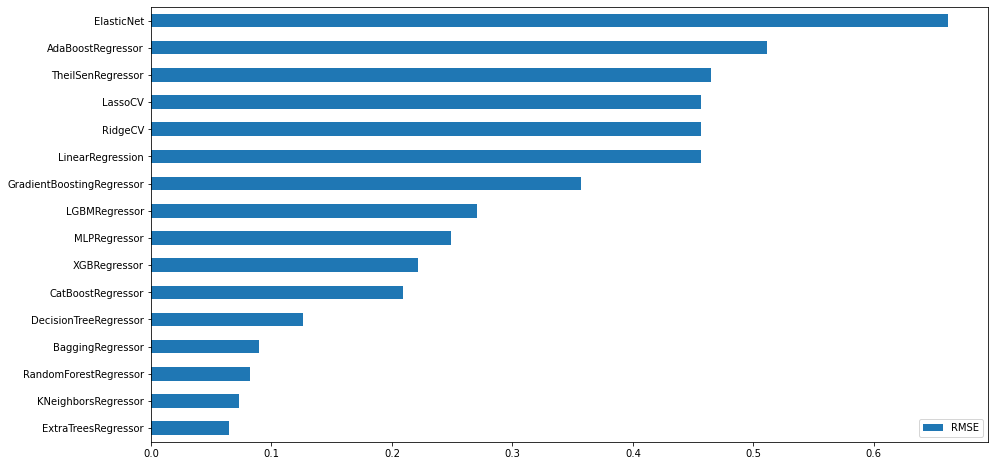

In [23]:
accu.T.sort_values(by="RMSE").plot(kind="barh",figsize=(15,8))

In [24]:
accu.T.sort_values(by="RMSE")

,RMSE
ExtraTreesRegressor,0.064895
KNeighborsRegressor,0.073456
RandomForestRegressor,0.082127
BaggingRegressor,0.089743
DecisionTreeRegressor,0.125978
CatBoostRegressor,0.208786
XGBRegressor,0.221270
MLPRegressor,0.249098
LGBMRegressor,0.270715
GradientBoostingRegressor,0.356993


In [25]:
#we have perfect scores no need for tuning
params = {
    'n_estimators': [10,50,100],
    #'criterion': ['mse', 'mae'],
    #'max_depth': [2,8,16,32,50],
    'max_features': ['auto','sqrt','log2'],    
    #'bootstrap': [True, False],
    #'warm_start': [True, False],
}

etr_model=GridSearchCV(ExtraTreesRegressor(),params,cv=10,n_jobs=-1,verbose=True).fit(X_train,y_train)


Fitting 10 folds for each of 9 candidates, totalling 90 fits


In [26]:
etr_model.best_params_

{'max_features': 'auto', 'n_estimators': 10}

In [27]:
etr_tuned=ExtraTreesRegressor(**etr_model.best_params_,n_jobs=-1).fit(X_train,y_train)
y_pred = etr_tuned.predict(X_test)
np.sqrt(mean_squared_error(y_test,y_pred))
#default model is better, tuning is computing cost

0.0723554659169554